# Mixed noise

## Import zone

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as ct
import pandas as pd
import warnings

from scipy.optimize import curve_fit
from functools import partial
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle, ConnectionPatch
from matplotlib.ticker import ScalarFormatter
from matplotlib import rcParams

# --- Global style (same as your main plot) ---
rcParams['font.family'] = 'STIXGeneral'
rcParams['mathtext.fontset'] = 'stix'
rcParams['axes.unicode_minus'] = False
rcParams.update({
    "font.size": 14,
    "axes.labelsize": 15,
    "axes.titlesize": 15,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "axes.linewidth": 1.2,
    "lines.linewidth": 1.5,
    "grid.alpha": 0.6,
    "grid.linestyle": "--",
    "figure.facecolor": "white",
    "axes.facecolor": "white",
})

from src.systems.linear_traps import ThreeRFTrap
from src.io.loading import load_threeRF_geometry
from src.geometry.geometry_utils import check_all_ccw

## Load trap geometry

In [2]:
geometry = load_threeRF_geometry("src/resources/ThreeRF_params.json")

# Trench width
trench_width = 5

# Set segmentation flags
flags = {
    "build_outer_RF": True,
    "build_central_RF": True,
}

# Build trap
trap = ThreeRFTrap(geometry, trench_width, flags)
system = trap.build()

check_all_ccw(system)

All electrodes are CCW.


## Build whole system

In this part we build the whole system and then we compute the minima positions, the value of the pseudopotential as the RF ratio changes and the secular frequencies

In [3]:
csi_values = np.linspace(-1., 1.5, 1001)
csi_values[csi_values == 0] = 1e-12
x0 = (0., 0., 350.)
x1 = (0., 0., 10.)
minimum_positions_0 = []
minimum_positions_1 = []
pot_values_0 = []
pot_values_1 = []
secular_frequencies = []

L = 1e-6 # um length scale
M = 40 * ct.atomic_mass # ion mass (calcium)
Q = 1 * ct.elementary_charge # ion charge (single-ion)
Omega = 2 * np.pi * 19e6
V0 = 100

scale = Q / (2 * Omega * np.sqrt(M))

for csi in csi_values:
    voltages = {
        "central_RF": {"attr": "rf", "value": csi},
        "outer_RF": {"attr": "rf", "value": 1},
    }

    system = trap.build(voltages)

    try:
        if csi > 0.75:
            x0[0] -= 1
            x1[0] += 1
        x0 = system.minimum(x0=(x0[0], x0[1], x0[2]), axis=(0,2), coord=np.identity(3), method="Powell")
        minimum_positions_0.append(x0)
        pot_values_0.append(scale**2 * system.potential(x=x0, derivative=0)[0] * (V0/L)**2)

        if csi > 0.16:
            x1 = system.minimum(x0=(x1[0], x1[1], x1[2]), axis=(0,2), coord=np.identity(3), method="Powell")
            pot_values_1.append(scale**2 * system.potential(x=x1, derivative=0)[0] * (V0/L)**2)
            minimum_positions_1.append(x1)
            
        # Compute secular frequencies
        curve_z = system.modes(x0)
        omega_sec = np.sqrt(abs(curve_z[0]) / M * (scale * V0 / L**2)**2)
        secular_frequencies.append(omega_sec)
    except:
        print(csi, "minimum not found")

/home/kallo27/anaconda3/lib/python3.11/site-packages/electrode-1.5+dev-py3.11-linux-x86_64.egg/electrode/system.py:439: RuntimeWarning: Method Powell does not use gradient information (jac).
  res = optimize.minimize(fun=f, x0=x0, jac=g, hess=h,
/home/kallo27/anaconda3/lib/python3.11/site-packages/electrode-1.5+dev-py3.11-linux-x86_64.egg/electrode/system.py:439: RuntimeWarning: Method Powell does not use Hessian information (hess).
  res = optimize.minimize(fun=f, x0=x0, jac=g, hess=h,


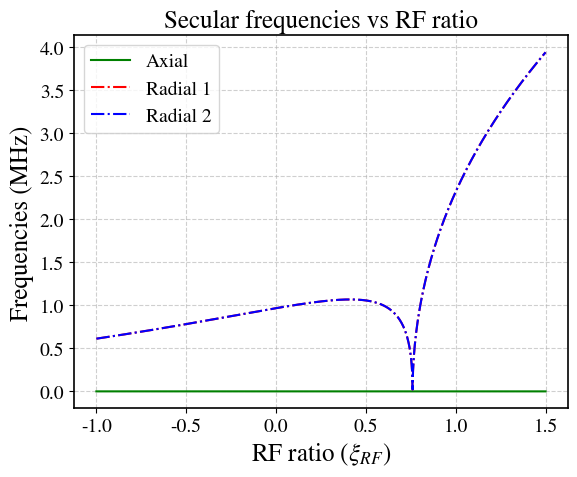

In [4]:
# Convert to arrays for slicing
sec_0 = np.array(secular_frequencies)[:,0]/(2*np.pi)/1e6
sec_1 = np.array(secular_frequencies)[:,1]/(2*np.pi)/1e6
sec_2 = np.array(secular_frequencies)[:,2]/(2*np.pi)/1e6

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 5))

# Plot z and x components for both datasets
ax.plot(csi_values, sec_0, label='Axial', color='green', linestyle='-')
ax.plot(csi_values, sec_1, label='Radial 1', color='red', linestyle='-.')
ax.plot(csi_values, sec_2, label='Radial 2', color='blue', linestyle='-.')

# Add labels and grid
ax.set_xlabel(r"RF ratio $(\xi_{{RF}})$", fontsize=18)
ax.set_ylabel('Frequencies (MHz)', fontsize=18)
ax.set_title('Secular frequencies vs RF ratio', fontsize=18)
ax.grid(True)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.show()

## Load experimental data

In [5]:
df = pd.read_excel("src/data/heating rate data.xlsx")

csi_exp = df.iloc[:, 0].values
h_exp = df.iloc[:, 1].values
error_h_exp = df.iloc[:, 2].values
freq_exp = df.iloc[:, 3].values

# Find corresponding indices
indices = []
for csi in csi_exp:
    idx = np.where(np.isclose(csi_values, np.round(csi, 2)))[0]
    if len(idx) == 0:
        raise ValueError(f"csi value {csi} not found in csi_values!")
    indices.append(idx[0])
indices = np.array(indices)

# Rescale y_data
for i in range(len(h_exp)):
    scale_factor = freq_exp[i] / sec_1[indices][i]
    h_exp[i] *= scale_factor
    error_h_exp[i] *= scale_factor  # Scale error accordingly

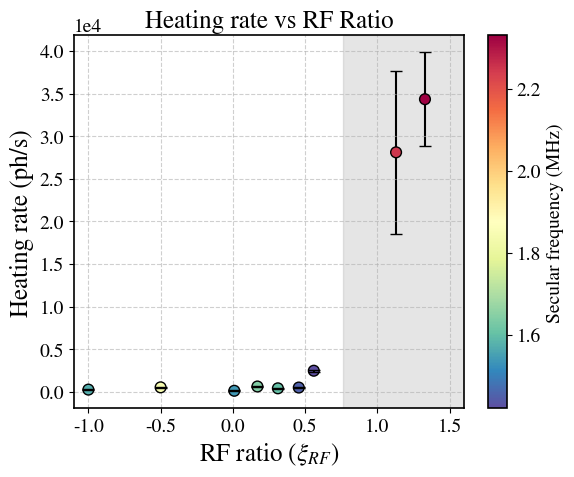

In [6]:
# Create the figure
plt.figure(figsize=(6, 5))

# Error bars in front (small errors)
plt.errorbar(
    csi_exp[:7],
    h_exp[:7],
    yerr=error_h_exp[:7],
    fmt='none',
    ecolor='black',
    capsize=4,
    zorder=3
)

# Error bars behind (large errors)
plt.errorbar(
    csi_exp[7:],
    h_exp[7:],
    yerr=error_h_exp[7:],
    fmt='none',
    ecolor='black',
    capsize=4,
    zorder=1
)

# Overlay colored scatter plot
sc = plt.scatter(
    csi_exp,
    h_exp,
    c=freq_exp,
    cmap='Spectral_r',  # You can choose another colormap
    s=60,            # Marker size
    edgecolor='black',
    zorder=2,
    label='Experimental data'
)

# Labels and formatting
plt.xlabel(r"RF ratio $(\xi_{{RF}})$", fontsize=18)
plt.ylabel('Heating rate (ph/s)', fontsize=18)
plt.title('Heating rate vs RF Ratio', fontsize=18)
plt.xlim(-1.1, 1.6)
plt.grid(True, linestyle='--', alpha=0.6, zorder=0)

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Secular frequency (MHz)', fontsize=14)

# Use scientific notation on both axes
ax = plt.gca()
ax.ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
ax.yaxis.offsetText.set_fontsize(14)

# Set tick label font sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.ax.yaxis.offsetText.set_fontsize(14)

min_index = np.argmin(sec_0)  # index of minimum y
csi_at_min = csi_values[min_index]

plt.axvspan(csi_at_min, plt.xlim()[1], color='gray', alpha=0.2, zorder=0)
plt.tight_layout()
plt.show()

## Compute gradient components

In [7]:
gradient_with_noise_O = []
gradient_without_noise_O = []
gradient_with_noise_I = []
gradient_without_noise_I = []
grad_phase = []
grad_E_O_values = []
grad_E_I_values = []
E_O_values = []
E_I_values = []

flags_outer = {"build_central_RF": False}
flags_central = {"build_outer_RF": False}

for i in range(len(csi_values)):
    voltages_outer = {"outer_RF": {"attr": "rf", "value": 1}}
    voltages_central = {"central_RF": {"attr": "rf", "value": csi_values[i]}}
    
    system_outer = trap.build(voltages_outer, flags_outer)
    system_central = trap.build(voltages_central, flags_central)
    
    try:
        grad_E_O = -system_outer.electrical_potential(x=minimum_positions_0[i], typ="rf", derivative=2, expand=True)[0] * (V0 / L**2)
        grad_E_O_values.append(grad_E_O)
        E_O = -system_outer.electrical_potential(x=minimum_positions_0[i], typ="rf", derivative=1)[0] * (V0 / L)
        E_O_values.append(E_O)
        
        grad_E_I = -system_central.electrical_potential(x=minimum_positions_0[i], typ="rf", derivative=2, expand=True)[0] * (V0 / L**2)
        grad_E_I_values.append(grad_E_I)
        E_I = -system_central.electrical_potential(x=minimum_positions_0[i], typ="rf", derivative=1)[0] * (V0 / L)
        E_I_values.append(E_I)

        gradient_with_noise_O.append(2*np.einsum("i, ij -> j", E_O, grad_E_O) + np.einsum("i, ij -> j", E_O, grad_E_I) 
                                     + np.einsum("i, ij -> j", E_I, grad_E_O))
        gradient_with_noise_I.append(2*np.einsum("i, ij -> j", E_I, grad_E_I) + np.einsum("i, ij -> j", E_O, grad_E_I) 
                                     + np.einsum("i, ij -> j", E_I, grad_E_O))
        gradient_without_noise_O.append(2*np.einsum("i, ij -> j", E_O, grad_E_O))
        gradient_without_noise_I.append(2*np.einsum("i, ij -> j", E_I, grad_E_I))
        
        
        grad_phase.append(np.einsum("i, ij -> j", E_O, grad_E_I) + np.einsum("i, ij -> j", E_I, grad_E_O))
        
    except:
        print(csi_values[i], "grad(phi) not found")

/home/kallo27/thesis/src/systems/linear_traps.py:236: UserWarning: Flag 'build_central_RF' is False, but RF geometry is provided.
  warnings.warn("Flag 'build_central_RF' is False, but RF geometry is provided.")
/home/kallo27/thesis/src/systems/linear_traps.py:240: UserWarning: Flag 'build_outer_RF' is False, but RF geometry is provided.
  warnings.warn("Flag 'build_outer_RF' is False, but RF geometry is provided.")


In [8]:
from tqdm import tqdm

def total_field(E_O_values, E_I_values):
    gradients = []

    for E_O, E_I in tqdm(zip(E_O_values, E_I_values), total=len(E_O_values)):
        # Compute scalar field E_O · E_I
        E_dot = E_O * E_I  # shape: (Nx, Ny, Nz)

        # Compute gradient of the scalar field
        E_tot = E_dot + E_O**2

        gradients.append(E_tot)

    return np.array(gradients)

## Compute heating rates

In [11]:
def heating_rates_outer(grad_E, S_V_O, axis=0):
    factor = 1 / (1 * M * ct.hbar * (sec_1*1e6*2*np.pi))    
    grad_pot_sqr = (np.array(grad_E)[:, axis] * scale**2)**2
    h_O = factor * grad_pot_sqr * S_V_O / V0**2
    return h_O

def heating_rates_inner(grad_E, S_V_I, axis=0):
    factor = 1 / (1 * M * ct.hbar * (sec_1*1e6*2*np.pi))    
    grad_pot_sqr = (np.array(grad_E)[:, axis] * scale**2)**2
    h_I = [factor[i] * grad_pot_sqr[i] * S_V_I / (V0 * csi_values[i])**2 
           for i in range(len(csi_values))]
    return np.array(h_I)

def heating_rates_mixed(grad_E1, grad_E2, S_mixed, axis=0):
    factor = 1 / (1 * M * ct.hbar * (sec_1 * 1e6 * 2 * np.pi))
    grad_pot_sqr1 = (np.array(grad_E1)[:, axis] * scale**2)**2
    grad_pot_sqr2 = (np.array(grad_E2)[:, axis] * scale**2)**2

    h_O = factor * grad_pot_sqr1 * S_mixed / V0**2
    h_I = factor * grad_pot_sqr2 * S_mixed / V0**2

    return np.array(h_O + h_I)

def heating_rates_phase(grad_E, S_phi, axis=0):
    factor = 1 / (256 * M * ct.hbar * (sec_1*1e6*2*np.pi))
    grad_pot_sqr = (np.array(grad_E)[:, axis] * scale**2)**2
    h_O = factor * grad_pot_sqr * S_phi
    return h_O

def heating_rates_total(grad_phi, grad_E1, grad_E2, S_phi, S_mixed, axis=0):
    hr_ampl = heating_rates_mixed(grad_E1, grad_E2, S_mixed, axis)
    hr_phi = heating_rates_phase(grad_phi, S_phi, axis)
    
    return hr_ampl + hr_phi

In [12]:
def plot_heating_rates(csi_values, heating_rate_x, heating_rate_z, csi_exp, h_exp, error_h_exp, title=None, log=False):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

    # Plot X axis
    axs[0].plot(csi_values, heating_rate_x, label="Heating rate", color="darkblue")
    axs[0].errorbar(csi_exp, h_exp, yerr=error_h_exp, fmt='o',
                    markersize=6, color='tab:red', ecolor='tab:grey',
                    capsize=4, label='Experimental data')

    axs[0].set_ylabel("Heating rate", fontsize=18)
    axs[0].set_xlabel(r"RF ratio $(\xi_{{RF}})$", fontsize=18)
    axs[0].set_title("X axis", fontsize=18)
    axs[0].grid(True)
    axs[0].tick_params(axis='both', which='major', labelsize=14)

    # Plot Z axis
    axs[1].plot(csi_values, heating_rate_z, label="Heating rate", color="darkblue")
    axs[1].errorbar(csi_exp, h_exp, yerr=error_h_exp, fmt='o',
                    markersize=6, color='tab:red', ecolor='tab:grey',
                    capsize=4, label='Experimental data')

    axs[1].set_ylabel("Heating rate", fontsize=18)
    axs[1].set_xlabel(r"RF ratio $(\xi_{{RF}})$", fontsize=18)
    axs[1].set_title("Y axis", fontsize=18)
    axs[1].grid(True)
    axs[1].tick_params(axis='both', which='major', labelsize=14)

    # Use scientific notation on both plots
    for ax in axs:
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((6, 6))  # Force 1e6 scale
        ax.yaxis.set_major_formatter(formatter)
        ax.ticklabel_format(style='scientific', axis='y', scilimits=(4, 4))
        ax.yaxis.offsetText.set_fontsize(14)

    if title:
        fig.suptitle(title, fontsize=20)
        
    if log:
        axs[0].set_yscale("log")
        axs[1].set_yscale("log")
        axs[0].set_ylim(1e0, 1e6)
        axs[1].set_ylim(1e0, 1e6)
    else:
        axs[0].set_ylim(-1e3, 4.1e4)
        axs[1].set_ylim(-1e3, 4.1e4)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3)
    plt.show()

In [13]:
heating_rate_O_x = heating_rates_outer(gradient_with_noise_O, S_V_O=3e-14, axis=0)
heating_rate_O_z = heating_rates_outer(gradient_with_noise_O, S_V_O=1.5e-13, axis=2)

heating_rate_I_x = heating_rates_inner(gradient_with_noise_I, S_V_I=3e-14, axis=0)
heating_rate_I_z = heating_rates_inner(gradient_with_noise_I, S_V_I=1.5e-13, axis=2)

heating_rate_mixed_x = heating_rates_mixed(gradient_with_noise_O, gradient_with_noise_I, S_mixed=1e-14, axis=0)
heating_rate_mixed_z = heating_rates_mixed(gradient_with_noise_O, gradient_with_noise_I, S_mixed=1e-14, axis=2)
heating_rate_mixed_y = heating_rates_mixed(gradient_with_noise_O, gradient_with_noise_I, S_mixed=1e-14, axis=1)

In [14]:
heating_x = heating_rates_total(grad_phase, gradient_with_noise_O, gradient_with_noise_I, S_phi=1.5e-16, S_mixed=1e-14, axis=0) 
heating_y = heating_rates_total(grad_phase, gradient_with_noise_O, gradient_with_noise_I, S_phi=1.5e-16, S_mixed=1e-14, axis=1)
heating_z = heating_rates_total(grad_phase, gradient_with_noise_O, gradient_with_noise_I, S_phi=1.5e-16, S_mixed=1e-14, axis=2)

In [16]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import ScalarFormatter

# Matplotlib options
rcParams['font.family'] = 'STIXGeneral'
rcParams['mathtext.fontset'] = 'stix'
rcParams['axes.unicode_minus'] = False
rcParams.update({
    "font.size": 14,
    "axes.labelsize": 15,
    "axes.titlesize": 15,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "axes.linewidth": 1.2,
    "lines.linewidth": 1.5,
    "grid.alpha": 0.6,
    "grid.linestyle": "--",
    "figure.facecolor": "white",
    "axes.facecolor": "white",
})

def plot_heating_and_frequency(csi_values, heating_rate_mixed_x, heating_rate_mixed_y, heating_rate_mixed_z, sec_1):
    colors = {"radial_x": "#003366", "axial": "#006400", "radial_y": "#8B0000"}

    fig, ax = plt.subplots(figsize=(8, 4))

    # --- Left axis: heating rates ---
    ax.plot(csi_values, heating_rate_mixed_y, label="Z axis", color=colors["radial_x"], zorder=1)
    ax.plot(csi_values, heating_rate_mixed_x, label="X axis", color=colors["radial_y"], zorder=2)
    ax.plot(csi_values, heating_rate_mixed_z, label="Y axis", color=colors["axial"], zorder=3)

    # Labels and formatting
    ax.set_ylabel("Heating rate")
    ax.set_xlabel(r"RF amplitude ratio $(\xi_{\mathrm{RF}})$")
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.tick_params(axis='both', which='major')

    # Scientific notation for heating rate
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((6, 6))
    ax.yaxis.set_major_formatter(formatter)
    ax.ticklabel_format(style='scientific', axis='y', scilimits=(4, 4))

    # --- Right axis: secular frequency ---
    ax2 = ax.twinx()
    ax2.plot(csi_values, sec_1, label="Radial secular frequency", linestyle='-.', color="tab:grey", linewidth=0.9, zorder=0)
    ax2.set_ylabel("Frequency (MHz)", color="tab:grey", rotation=270, labelpad=20)
    ax2.tick_params(axis='y', labelcolor="tab:grey")

    # --- Align zeros: adjust the right axis to match the left one ---
    left_min, left_max = ax.get_ylim()
    right_min, right_max = 0, 6  # desired nominal range before alignment

    # Compute scale so that zero lines up with the left axis zero
    right_span = right_max - right_min
    left_span = left_max - left_min
    adjusted_right_max = right_span * (left_max / left_span)
    ax2.set_ylim(left_min/left_span*right_span, adjusted_right_max)

    # --- Combine legends ---
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc="best")

    # --- Highlighted vertical span ---
    ax.axvspan(0.76, 1.5, color="#FBE201", alpha=0.5, zorder=0)

    plt.tight_layout()
    return fig

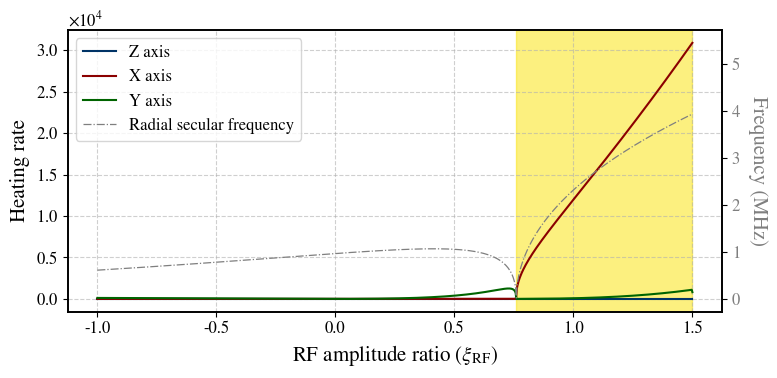

In [17]:
fig = plot_heating_and_frequency(csi_values, heating_rate_mixed_x, heating_rate_mixed_y, heating_rate_mixed_z, sec_1)
fig.savefig("/home/kallo27/thesis/thesis_images/hr_amplitude_noise.pdf", bbox_inches="tight")

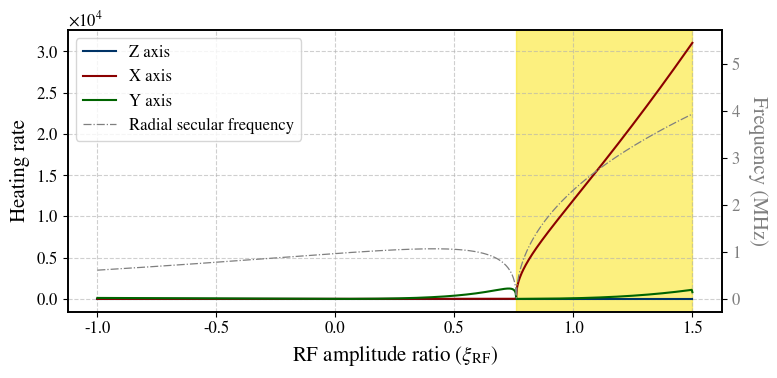

In [18]:
fig = plot_heating_and_frequency(csi_values, heating_x, heating_y, heating_rate_mixed_z, sec_1)

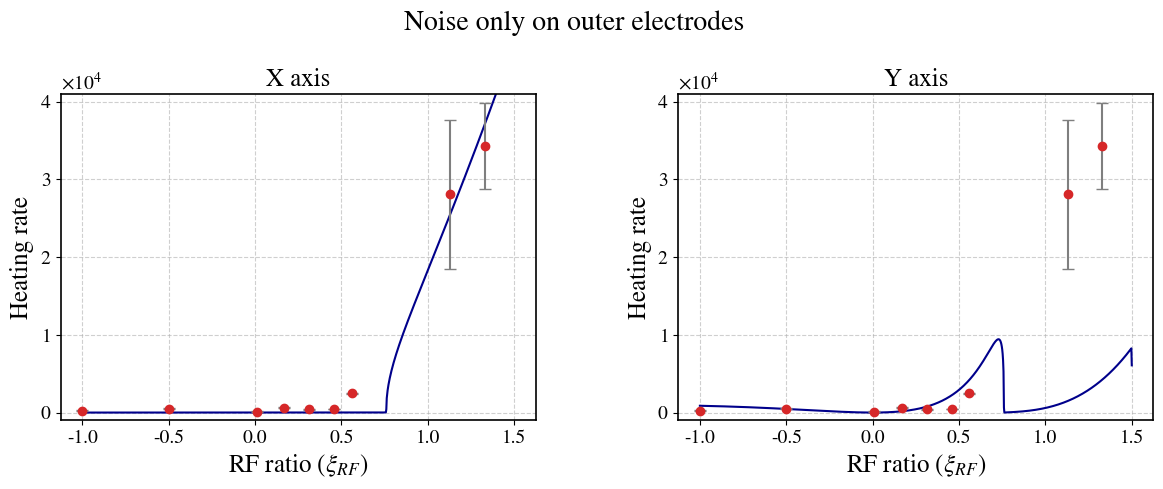

In [19]:
plot_heating_rates(csi_values, heating_rate_O_x, heating_rate_O_z, csi_exp, h_exp, error_h_exp, 
                   "Noise only on outer electrodes")

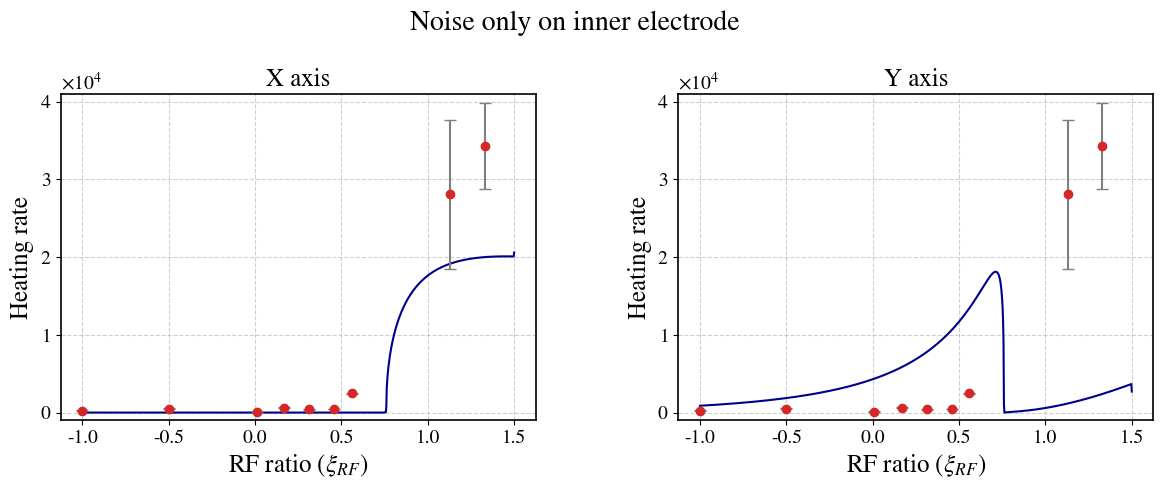

In [20]:
plot_heating_rates(csi_values, heating_rate_I_x, heating_rate_I_z, csi_exp, h_exp, error_h_exp,
                   "Noise only on inner electrode")

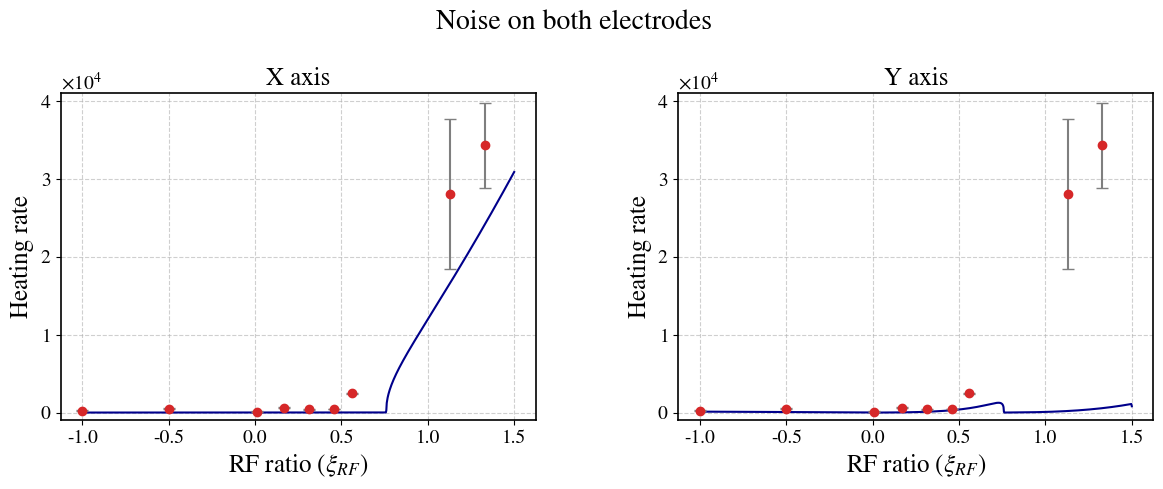

In [21]:
plot_heating_rates(csi_values, heating_rate_mixed_x, heating_rate_mixed_z, csi_exp, h_exp, error_h_exp,
                   "Noise on both electrodes")

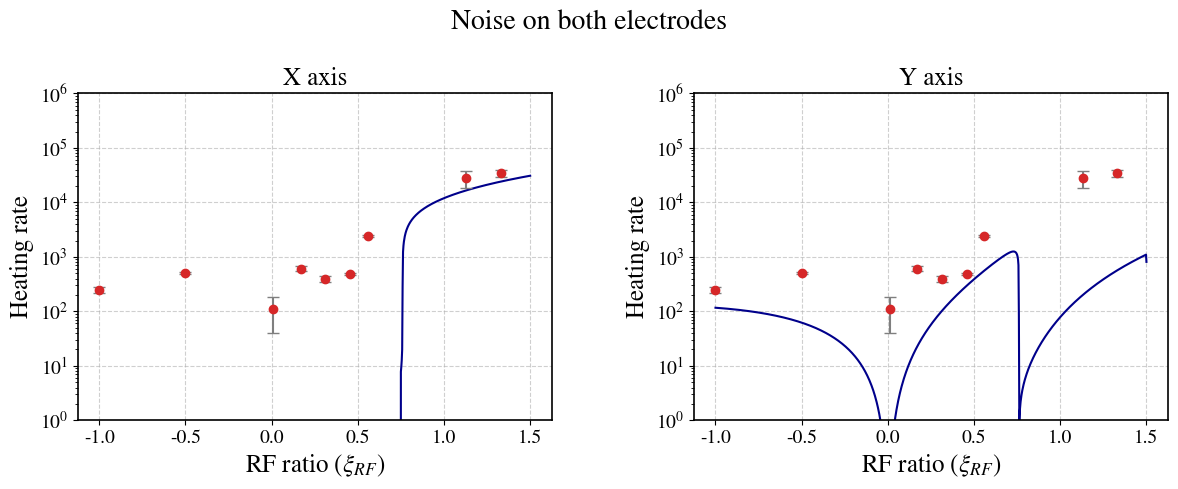

In [22]:
plot_heating_rates(csi_values, heating_rate_mixed_x, heating_rate_mixed_z, csi_exp, h_exp, error_h_exp,
                   "Noise on both electrodes", log=True)

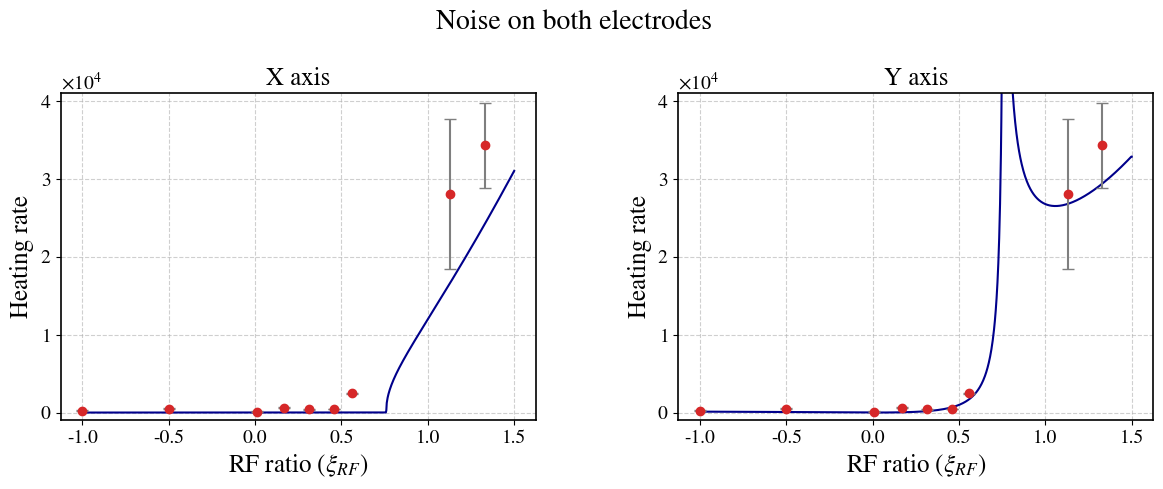

In [23]:
plot_heating_rates(csi_values, heating_x, heating_z, csi_exp, h_exp, error_h_exp,"Noise on both electrodes", log=False)

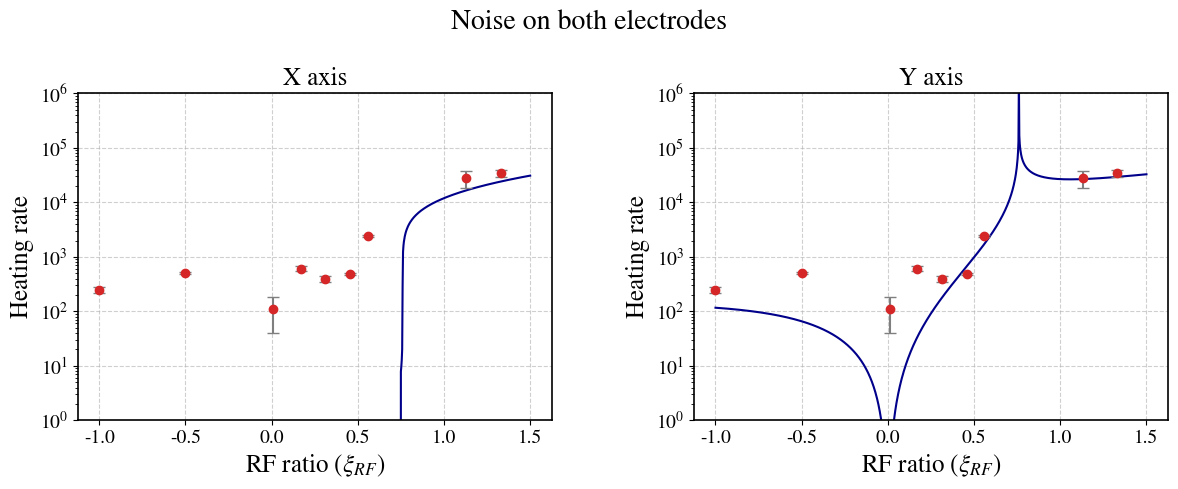

In [24]:
plot_heating_rates(csi_values, heating_x, heating_z, csi_exp, h_exp, error_h_exp,"Noise on both electrodes", log=True)

## Fit heating rates

In [96]:
# Wrapper for curve_fit — x is ignored
def model_hr(dummy_x, S_phi, S_mixed, axis=0):
    hr = heating_rates_total(grad_phase, gradient_with_noise_O, gradient_with_noise_I, S_phi=S_phi, S_mixed=S_mixed, axis=axis)
    return hr[indices]

In [97]:
# Dummy x data (ignored by the model, but required by curve_fit)
x_dummy = np.zeros(len(h_exp))

# Outer only
popt_outer_x, pcov_outer_x = curve_fit(
    partial(model_hr, axis=0),
    x_dummy,
    h_exp,
    p0=[1e-16, 1e-14],
    sigma=error_h_exp,
    absolute_sigma=True,
    bounds=([0, 0], [np.inf, np.inf])  # Enforce S_V_O ≥ 0
)

popt_outer_z, pcov_outer_z = curve_fit(
    partial(model_hr, axis=2),
    x_dummy,
    h_exp,
    p0=[1e-16, 1e-14],
    sigma=error_h_exp,
    absolute_sigma=True,
    bounds=([0, 0], [np.inf, np.inf])  # Enforce S_V_O ≥ 0
)


print("BEST PARAMETERS FROM THE FIT")
print("------------------------------------------------")
print("------------------------------------------------")

# Best-fit values
S_phi_best_x, S_mixed_best_x = popt_outer_x

# Standard deviations
S_phi_err_x, S_mixed_err_x = np.sqrt(np.diag(pcov_outer_x))

print("X axis")

print("Best S_phi:", S_phi_best_x)
print("Best S_mixed:", S_mixed_best_x)

print("--------------------")

print(f"Fit error S_phi: {S_phi_err_x}")
print(f"Fit error S_mixed: {S_mixed_err_x}")


print("------------------------------------------------")
print("------------------------------------------------")

# Best-fit values
S_phi_best_z, S_mixed_best_z = popt_outer_z

# Standard deviations
S_phi_err_z, S_mixed_err_z = np.sqrt(np.diag(pcov_outer_z))

print("Z axis")

print("Best S_phi:", S_phi_best_z)
print("Best S_mixed:", S_mixed_best_z)

print("--------------------")

print(f"Fit error S_phi: {S_phi_err_z}")
print(f"Fit error S_mixed: {S_mixed_err_z}")


BEST PARAMETERS FROM THE FIT
------------------------------------------------
------------------------------------------------
X axis
Best S_phi: 2.3713067814176043e-19
Best S_mixed: 1.817328959931175e-14
--------------------
Fit error S_phi: 4.4817318908609974e-14
Fit error S_mixed: 9.134689074139097e-15
------------------------------------------------
------------------------------------------------
Z axis
Best S_phi: 1.2310052233797992e-16
Best S_mixed: 4.817976100046444e-15
--------------------
Fit error S_phi: 1.4399312400926005e-17
Fit error S_mixed: 4.990965532962802e-16


In [101]:
heating_rate_x = heating_rates_total(grad_phase, gradient_with_noise_O, gradient_with_noise_I, S_phi=S_phi_best_x, S_mixed=S_mixed_best_x, axis=0)
heating_rate_z = heating_rates_total(grad_phase, gradient_with_noise_O, gradient_with_noise_I, S_phi=S_phi_best_z, S_mixed=S_mixed_best_z, axis=2)

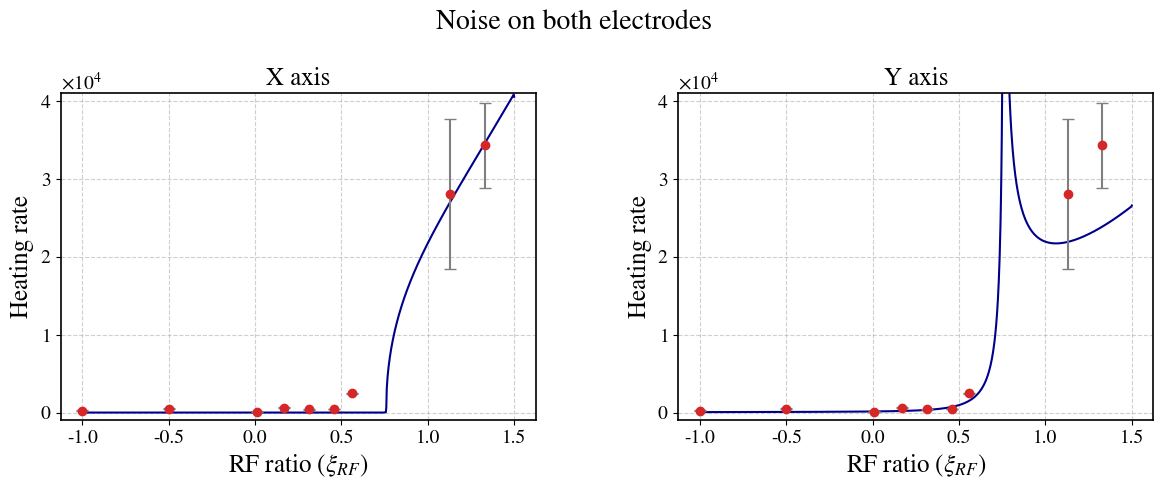

In [102]:
plot_heating_rates(csi_values, heating_rate_x, heating_rate_z, csi_exp, h_exp, error_h_exp,
                   "Noise on both electrodes")

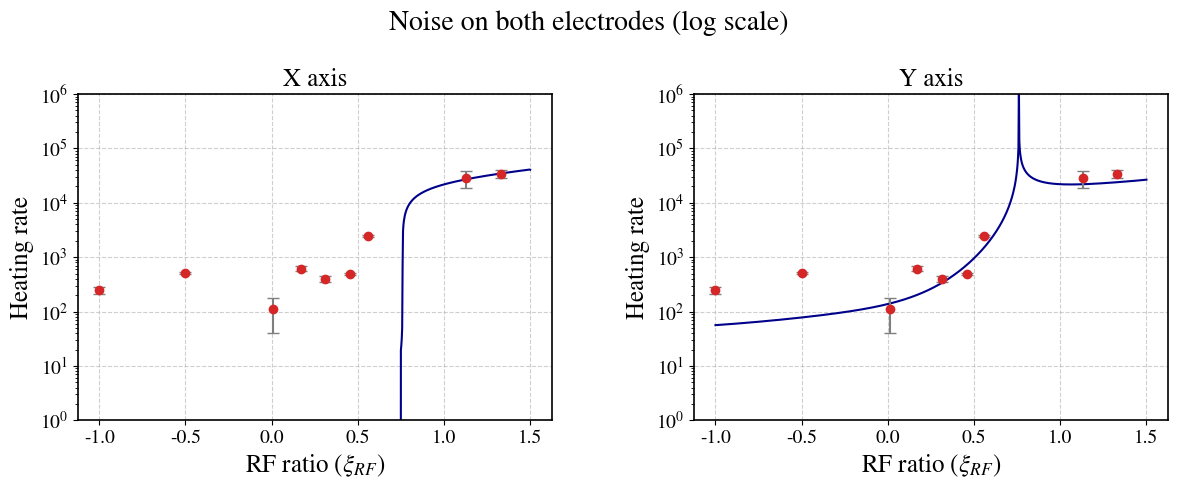

In [103]:
plot_heating_rates(csi_values, heating_rate_x, heating_rate_z, csi_exp, h_exp, error_h_exp,
                   "Noise on both electrodes (log scale)", log=True)

## Heating rates when considering coupling

In [37]:
def hr_outer_coupling(grad_E, S_V_O, theta_rad=0):
    n = np.array([np.cos(theta_rad), 0.0, np.sin(theta_rad)])  # shape (3,)
    
    grad_proj = np.einsum('ni,i->n', grad_E, n)  # shape (1001,)
    grad_pot_sqr = (grad_proj * scale)**2  # shape (1001,)

    factor = 1 / (1 * M * ct.hbar * (sec_1 * 1e6 * 2 * np.pi))    
    h_O = factor * grad_pot_sqr * S_V_O / V0**2  # shape (1001,)
    
    return h_O

def hr_inner_coupling(grad_E, S_V_I, theta_rad=0):
    n = np.array([np.cos(theta_rad), 0.0, np.sin(theta_rad)])
    grad_proj = (np.einsum('ni,i->n', grad_E, n))
    grad_pot_sqr = (grad_proj * scale**2)**2

    factor = 1 / (1 * M * ct.hbar * (sec_1 * 1e6 * 2 * np.pi))    
    h_I = [factor[i] * grad_pot_sqr[i] * S_V_I / (V0 * csi_values[i])**2 
           for i in range(len(csi_values))]
    return np.array(h_I)

def hr_mixed_coupling(grad_E1, grad_E2, S_total, r, theta_rad=0):
    S_V_O = r / (1 + r) * S_total
    S_V_I = 1 / (1 + r) * S_total

    n = np.array([np.cos(theta_rad), 0.0, np.sin(theta_rad)])
    grad_proj1 = (np.einsum('ni,i->n', grad_E1, n))
    grad_proj2 = (np.einsum('ni,i->n', grad_E2, n))
    grad_pot_sqr1 = (grad_proj1 * scale**2)**2
    grad_pot_sqr2 = (grad_proj2 * scale**2)**2    

    factor = 1 / (1 * M * ct.hbar * (sec_1 * 1e6 * 2 * np.pi))
    h_O = factor * grad_pot_sqr1 * S_V_O / V0**2
    h_I = [factor[i] * grad_pot_sqr2[i] * S_V_I / (V0 * csi_values[i])**2 
           for i in range(len(csi_values))]

    return np.array(h_O + h_I)

In [38]:
def plot_heating_rates_rotated(csi_values, heating_rate, csi_exp, h_exp, error_h_exp, title=None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

    # Plot X axis
    axs[0].plot(csi_values, heating_rate, label="Heating rate", color="darkblue")
    axs[0].errorbar(csi_exp, h_exp, yerr=error_h_exp, fmt='o',
                    markersize=6, color='tab:red', ecolor='tab:grey',
                    capsize=4, label='Experimental data')

    axs[0].set_ylabel("Heating rate", fontsize=18)
    axs[0].set_xlabel(r"RF ratio $(\xi_{{RF}})$", fontsize=18)
    axs[0].set_title("Linear scale", fontsize=18)
    axs[0].grid(True)
    axs[0].set_ylim(-1e3, 4.1e4)
    axs[0].tick_params(axis='both', which='major', labelsize=14)

    # Plot Z axis
    axs[1].plot(csi_values, heating_rate, label="Heating rate", color="darkblue")
    axs[1].errorbar(csi_exp, h_exp, yerr=error_h_exp, fmt='o',
                    markersize=6, color='tab:red', ecolor='tab:grey',
                    capsize=4, label='Experimental data')

    axs[1].set_ylabel("Heating rate", fontsize=18)
    axs[1].set_xlabel(r"RF ratio $(\xi_{{RF}})$", fontsize=18)
    axs[1].set_title("Log scale", fontsize=18)
    axs[1].grid(True)
    axs[1].tick_params(axis='both', which='major', labelsize=14)

    # Use scientific notation on both plots
    for ax in axs:
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((6, 6))  # Force 1e6 scale
        ax.yaxis.set_major_formatter(formatter)
        ax.ticklabel_format(style='scientific', axis='y', scilimits=(4, 4))
        ax.yaxis.offsetText.set_fontsize(14)

    axs[1].set_yscale("log")
    axs[1].set_ylim(1e0, 1e6)

    if title:
        fig.suptitle(title, fontsize=20)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3)
    plt.show()

In [39]:
heating_rates_outer_rotated = hr_outer_coupling(gradient_with_noise_O, S_V_O=4e-14, theta_rad=np.deg2rad(20))
heating_rates_inner_rotated = hr_inner_coupling(gradient_with_noise_I, S_V_I=4e-15, theta_rad=np.deg2rad(20))
heating_rates_mixed_rotated = hr_mixed_coupling(gradient_with_noise_O, gradient_with_noise_I, 
                                                S_total=1e-14, r=4, theta_rad=np.deg2rad(20))

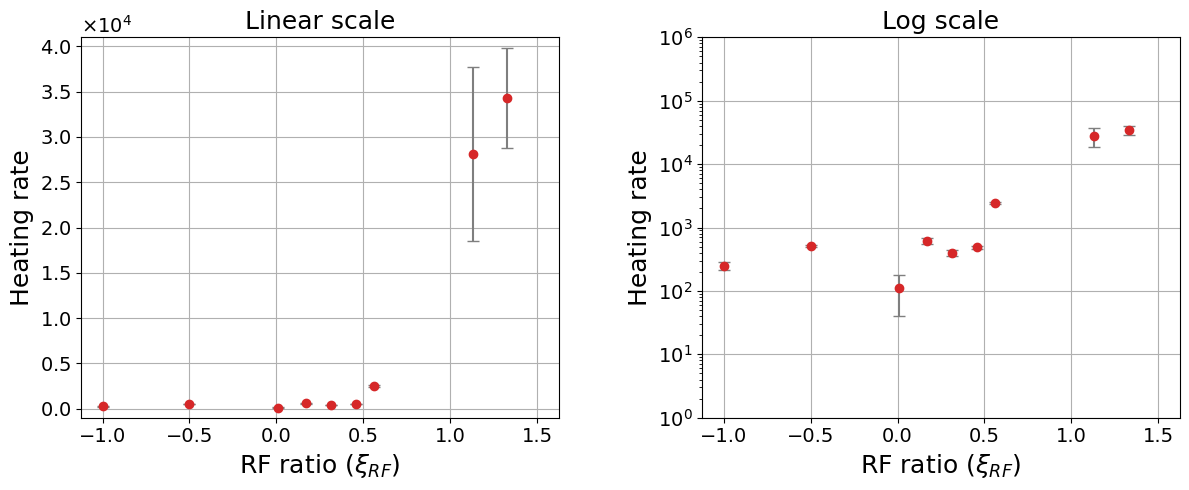

In [40]:
plot_heating_rates_rotated(csi_values, heating_rates_outer_rotated, csi_exp, h_exp, error_h_exp)

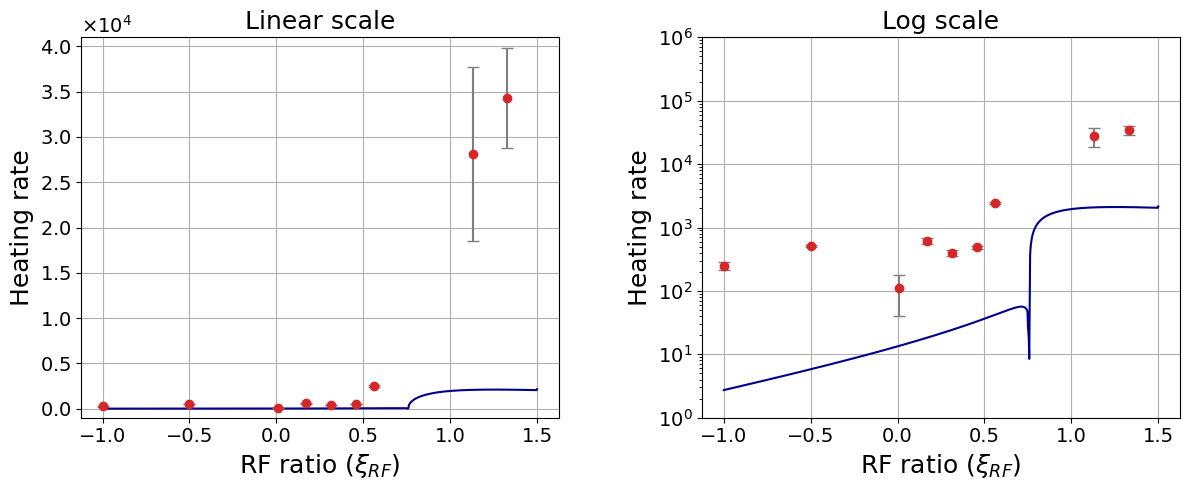

In [41]:
plot_heating_rates_rotated(csi_values, heating_rates_inner_rotated, csi_exp, h_exp, error_h_exp)

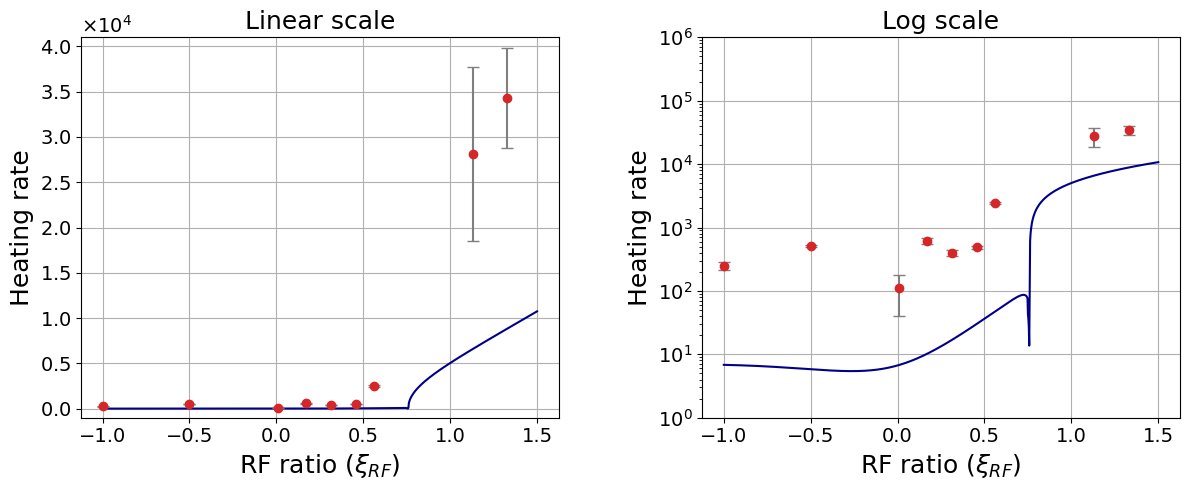

In [42]:
plot_heating_rates_rotated(csi_values, heating_rates_mixed_rotated, csi_exp, h_exp, error_h_exp)

## Fit when the coupling is present

In [43]:
# Wrapper for curve_fit — x is ignored
def model_outer_coupling(dummy_x, S_V_O, theta):
    hr = hr_outer_coupling(gradient_with_noise_O, S_V_O=S_V_O, theta_rad=np.deg2rad(theta))
    return hr[indices]

def model_inner_coupling(dummy_x, S_V_I, theta):
    hr = hr_inner_coupling(gradient_with_noise_I, S_V_I=S_V_I, theta_rad=np.deg2rad(theta))
    return hr[indices]

def model_mixed_coupling(xdummy, S_total, r, theta):
    hr = hr_mixed_coupling(gradient_with_noise_O, gradient_with_noise_I, S_total, r, theta_rad=np.deg2rad(theta))
    return hr[indices]

In [ ]:
# Dummy x data (ignored by the model, but required by curve_fit)
x_dummy = np.zeros(len(h_exp))

# Outer only
popt_outer, pcov_outer = curve_fit(
    model_outer_coupling,
    x_dummy,
    h_exp,
    p0=[1e-14, 20],
    sigma=error_h_exp,
    absolute_sigma=True,
    bounds=([0, 0], [np.inf, 90])
)

# Inner only
popt_inner, pcov_inner = curve_fit(
    model_inner_coupling,
    x_dummy,
    h_exp,
    p0=[1e-14, 20],
    sigma=error_h_exp,
    absolute_sigma=True,
    bounds=([0, 0], [np.inf, 90])
)

# Mixed (outer + inner)
popt_mixed, pcov_mixed = curve_fit(
    model_mixed_coupling,
    x_dummy,
    h_exp,
    p0=[1e-14, 1, 20],
    sigma=error_h_exp,
    absolute_sigma=True,
    bounds=([0, 0, 0], [np.inf, np.inf, 90])
)


best_S_V_O, theta_outer = popt_outer
best_S_V_I, theta_inner = popt_inner

best_S_total, best_r, theta_mixed = popt_mixed
pcov_rs = pcov_mixed[np.ix_([1, 0], [1, 0])]
best_S_V_O_mixed = best_r / (1 + best_r) * best_S_total
best_S_V_I_mixed = 1 / (1 + best_r) * best_S_total

J_O = np.array([best_r / (1 + best_r), best_S_total / (1 + best_r)**2])
J_I = np.array([1 / (1 + best_r), -best_S_total / (1 + best_r)**2])

var_S_V_O = J_O @ pcov_rs @ J_O
var_S_V_I = J_I @ pcov_rs @ J_I

print("BEST PARAMETERS FROM THE FIT")
print("------------------------------------------------")
print("------------------------------------------------")

print(f"Best S_V_O: {best_S_V_O:.3e}, Theta: {theta_outer:.1f}°")
print(f"Best S_V_I: {best_S_V_I:.3e}, Theta: {theta_inner:.1f}°")
print(f"Best S_V_O (mixed): {best_S_V_O_mixed:.3e}")
print(f"Best S_V_I (mixed): {best_S_V_I_mixed:.3e}")
print(f"Theta: {theta_mixed:.1f}°")
print("--------------------")

print(f"Fit error outer: {np.sqrt(pcov_outer[0][0]):.3e}, {np.sqrt(pcov_outer[1][1]):.1f}°")
print(f"Fit error inner: {np.sqrt(pcov_inner[0][0]):.3e}, {np.sqrt(pcov_inner[1][1]):.1f}°")
print(f"Fit error mixed: {np.sqrt(var_S_V_O):.3e}, {np.sqrt(var_S_V_I):.3e}, {np.sqrt(pcov_mixed[2][2]):.1f}°")

print("------------------------------------------------")
print("------------------------------------------------")

BEST PARAMETERS FROM THE FIT
------------------------------------------------
------------------------------------------------
Best S_V_O: 1.912e-16, Theta: 21.4°
Best S_V_I: 6.621e-14, Theta: 22.7°
Best S_V_O (mixed): 8.261e-14
Best S_V_I (mixed): 2.341e-15
Theta: 46.5°
--------------------
Fit error outer: 3.290e-44, 0.0°
Fit error inner: 2.111e-15, 0.0°
Fit error mixed: 1.654e-31, 1.654e-31, 0.0°
------------------------------------------------
------------------------------------------------


In [45]:
heating_rates_outer_rotated = hr_outer_coupling(gradient_with_noise_O, S_V_O=best_S_V_O, theta_rad=np.deg2rad(theta_outer))
heating_rates_inner_rotated = hr_inner_coupling(gradient_with_noise_I, S_V_I=best_S_V_I, theta_rad=np.deg2rad(theta_inner))
heating_rates_mixed_rotated = hr_mixed_coupling(gradient_with_noise_O, gradient_with_noise_I, 
                                                S_total=best_S_total, r=best_r, theta_rad=np.deg2rad(theta_mixed))

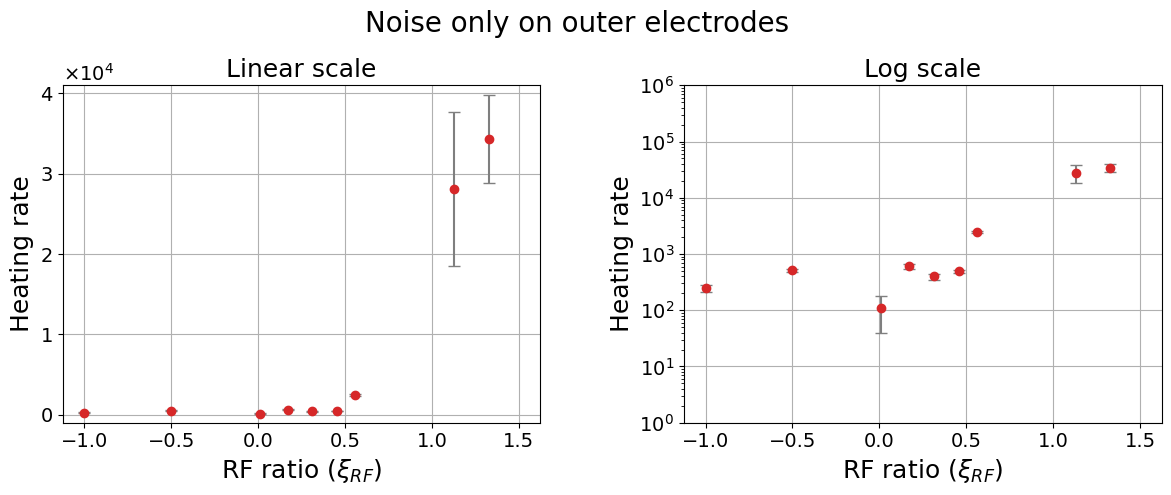

In [46]:
plot_heating_rates_rotated(csi_values, heating_rates_outer_rotated, csi_exp, h_exp, error_h_exp, 
                           "Noise only on outer electrodes")

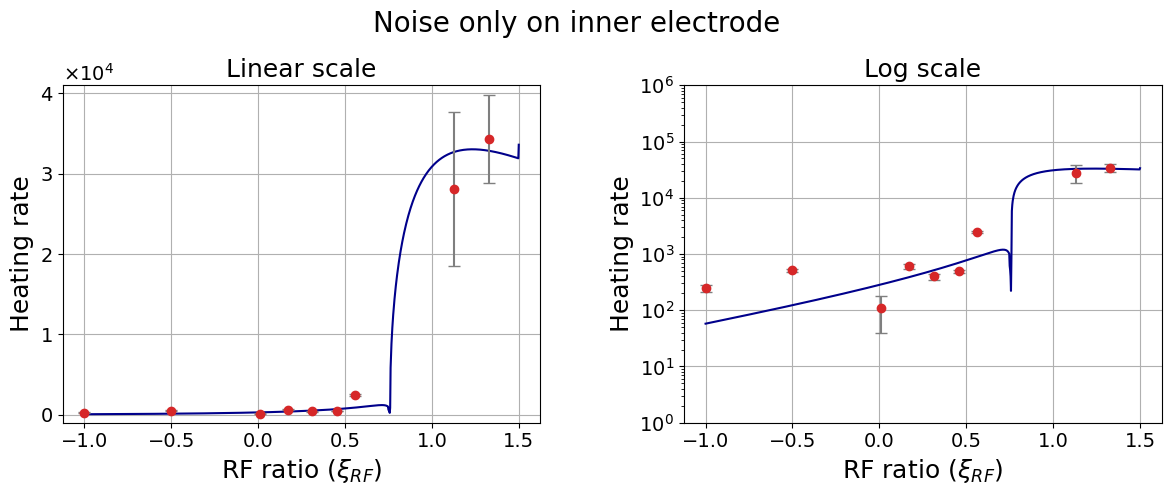

In [47]:
plot_heating_rates_rotated(csi_values, heating_rates_inner_rotated, csi_exp, h_exp, error_h_exp,
                           "Noise only on inner electrode")

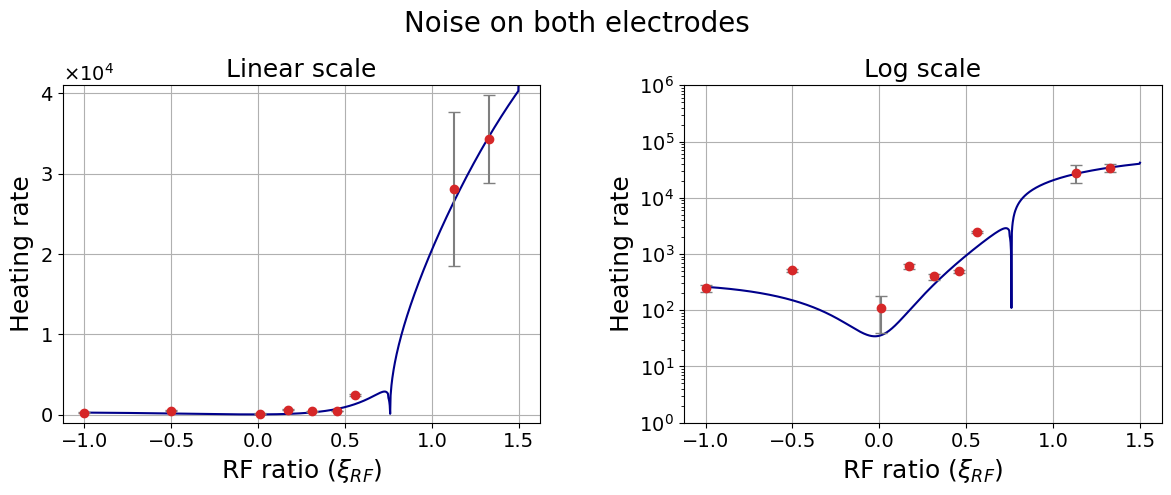

In [48]:
plot_heating_rates_rotated(csi_values, heating_rates_mixed_rotated, csi_exp, h_exp, error_h_exp,
                           "Noise on both electrodes")